## Group No 35

## Group Member Names:
1. Sushil Kumar (2023AA05849)
2. Hemant Kumar Parakh (2023AA05741)
3. Nagineni Sathish Babu (2023AA05585)
4. Uppada Siddhartha Reddy (2023AA05298)



## Problem 3. Advanced Object Tracking and Detection in Video Streams

Problem Statement: Develop an advanced object tracking and detection system that utilizes the Faster R-CNN model to accurately identify and track multiple objects in video streams. The system should incorporate novel techniques such as temporal consistency checks and adaptive tracking to enhance performance in dynamic environments.

    Objectives:
        a. Extract frames from video sequences and perform normalization to standardize input data.
        b. Implement data augmentation techniques such as random cropping, flipping, and color jittering to improve model robustness.
        c. Design a Faster R-CNN model for object detection, fine-tuning it on the selected dataset.
        d. Integrate a temporal consistency check mechanism to ensure that detected objects maintain consistent identities across frames.
        e. Implement adaptive tracking algorithms (e.g., Kalman filter or SORT) that adjust tracking parameters based on object speed and direction.
        f. Evaluate the model's performance using metrics such as mean Average Precision (mAP), tracking accuracy, and identity switch rate.
        g. Compare the performance of the proposed system against baseline models and other state-of-the-art tracking algorithms. (Optional)
        * Data Preprocessing:
        * Model Development:
        * Evaluation:
    Dataset: https://motchallenge.net/data/
    Sample Papers:
        "Real-Time Object Detection and Tracking Using Faster R-CNN" - https://arxiv.org/abs/2006.04567
        "A Survey on Object Detection and Tracking" - https://www.sciencedirect.com/science/article/pii/S0031320321001234


# **Multiple Object Tracking with PyTorch**



**Multiple Object Tracking**
- Object tracking is one of the tasks in computer vision, which is detecting an object and searching for that object in a video or a series of images (actually both meaning the same thing).
- Surveillance cameras in public places for spotting suspicious activities or crimes, and a computer system called 'Hawk-eye' for tracking the trajectory of the ball in various sports are typical examples of applying object tracking in a real life.


**Goals**


1. We will use MOT17Det Dataset
2. First part: Object Detection with **Faster R-CNN**
3. Second part: Multiple Object(ID) Tracking with **Kalman filter** or **Simple Online and Realtime Tracking (SORT)** algorithm



---




## Required libs installation

In [1]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=36d8e2895f2ee5052bdcf8a2c00ef55e357e70ba9fde9342c169f29eb5ab7b39
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


## Imports

In [2]:
# Import necessary libraries
import os
import json
import collections
import numpy as np
import cv2
import torch
import torchvision
import imageio
import skimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from os.path import join
from PIL import Image
from torchvision import transforms as T
from filterpy.kalman import KalmanFilter
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from IPython.display import Image, HTML, Video
import moviepy.editor as mp




  if event.key is 'enter':



### Check if GPU is available. We may use GPU wherever required

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset download
---


**Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
* We can use anyother dataset available on MOT Challenge i.e. MOT15, MOT16, MOT17 and etc. We have selected MOT17Det as a random selection considering small size.
*   We have used only MOT17-09 dataset for our assignment to demostrate the multiple object detection. We can change the path in the code and execute with other dataset as well.
* We have tried mixing multiple datasets but computation become very high so sticked to only MOT17-09 dataset.


---

Link: https://motchallenge.net/data/MOT17Det.zip



In [4]:
# Define root paths
root = 'content'
MOT_PATH = "MOT/"

# Create necessary directories
os.makedirs(MOT_PATH, exist_ok=True)
os.makedirs(join(MOT_PATH, 'save/'), exist_ok=True)

In [5]:
# Download MOT17Det Dataset & unzip

!wget -P "{MOT_PATH}" https://motchallenge.net/data/MOT17Det.zip
!cd "{MOT_PATH}";unzip MOT17Det.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/MOT17-02/img1/000323.jpg  
  inflating: train/MOT17-02/img1/000324.jpg  
  inflating: train/MOT17-02/img1/000325.jpg  
  inflating: train/MOT17-02/img1/000326.jpg  
  inflating: train/MOT17-02/img1/000327.jpg  
  inflating: train/MOT17-02/img1/000328.jpg  
  inflating: train/MOT17-02/img1/000329.jpg  
  inflating: train/MOT17-02/img1/000330.jpg  
  inflating: train/MOT17-02/img1/000331.jpg  
  inflating: train/MOT17-02/img1/000332.jpg  
  inflating: train/MOT17-02/img1/000333.jpg  
  inflating: train/MOT17-02/img1/000334.jpg  
  inflating: train/MOT17-02/img1/000335.jpg  
  inflating: train/MOT17-02/img1/000336.jpg  
  inflating: train/MOT17-02/img1/000337.jpg  
  inflating: train/MOT17-02/img1/000338.jpg  
  inflating: train/MOT17-02/img1/000339.jpg  
  inflating: train/MOT17-02/img1/000340.jpg  
  inflating: train/MOT17-02/img1/000341.jpg  
  inflating: train/MOT17-02/img1/000342.jpg  
  inflating: train/MOT17-02/i

In [6]:
# Remove unwanted data for google coloab drive volume issue (optional)

!cd "{MOT_PATH}";rm -rf test
!cd "{MOT_PATH}";rm -rf train/MOT17-02;rm -rf train/MOT17-04;rm -rf train/MOT17-05
!cd "{MOT_PATH}";rm -rf train/MOT17-10;rm -rf train/MOT17-11;rm -rf train/MOT17-13

In [7]:
import sys

motdata = join(MOT_PATH,'train/MOT17-09/img1/')
sys.path.append(motdata)
annotations_path = join(MOT_PATH, 'train/MOT17-09/gt/gt.txt')
sys.path.append(annotations_path)

### Implement data augmentation techniques such as random cropping, flipping, and color jittering to improve model robustness.

In [8]:
# Data Augmentation
augmentations = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    T.ToTensor()
])

In [9]:
from PIL import Image

# Augmented image
def augment_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = augmentations(img)
    return img.permute(1, 2, 0).numpy()

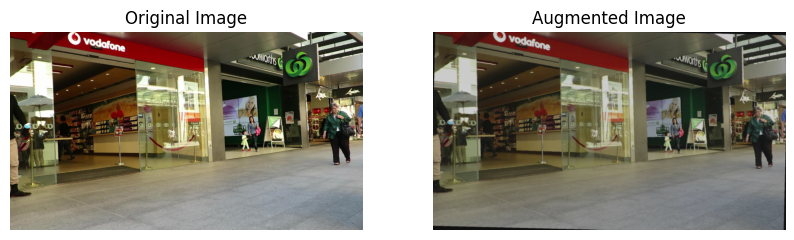

In [10]:
# Display an example original and augmented image
list_motdata = sorted(os.listdir(motdata))
img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_ex)
plt.axis('off')
plt.title("Original Image")

aug_img = augment_image(img_ex_path)
plt.subplot(1, 2, 2)
plt.imshow(aug_img)
plt.axis('off')
plt.title("Augmented Image")
plt.show()




---


**Object Detection with Faster R-CNN**

*  We use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.





---




In [11]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 202MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Pretrainined Faster R-CNN model is working fine. Lets try to fine-tune the model for selected dataset MOT17-09

In [12]:
"""
from torch.utils.data import DataLoader, Dataset

# Custom Dataset for MOT17-09
class MOT17Dataset(Dataset):
    def __init__(self, img_folder, annotation_file, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.annotations = self.load_mot_annotations(annotation_file)  # Call custom loading function

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = join(self.img_folder, ann["filename"])
        img = Image.open(img_path).convert("RGB")
        boxes = torch.tensor(ann["boxes"], dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assume single class: 'object'
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64) # Assume no crowd
        # area of bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}
        if self.transform:
            img = self.transform(img)
        return img, target

    def load_mot_annotations(self, annotation_file):
        # Loads MOT annotations from a text file.
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                data = line.strip().split(',')
                frame_id = int(data[0])
                # Only process pedestrian objects (class 1)
                # to be able to fine-tune detection network
                if int(data[7]) == 1 and int(data[6]) == 1: # confidence, visibility
                  filename = f"{frame_id:06d}.jpg"
                  bbox = list(map(float, data[2:6]))  # x, y, width, height
                  annotations.append({"filename": filename, "boxes": [bbox]})
        return annotations

# Load Dataset
train_dataset = MOT17Dataset(motdata, annotations_path, transform=augmentations)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
"""

'\nfrom torch.utils.data import DataLoader, Dataset \n\n# Custom Dataset for MOT17-09\nclass MOT17Dataset(Dataset):\n    def __init__(self, img_folder, annotation_file, transform=None):\n        self.img_folder = img_folder\n        self.transform = transform\n        self.annotations = self.load_mot_annotations(annotation_file)  # Call custom loading function\n\n    def __len__(self):\n        return len(self.annotations)\n\n    def __getitem__(self, idx):\n        ann = self.annotations[idx]\n        img_path = join(self.img_folder, ann["filename"])\n        img = Image.open(img_path).convert("RGB")\n        boxes = torch.tensor(ann["boxes"], dtype=torch.float32)\n        labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assume single class: \'object\'\n        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64) # Assume no crowd\n        # area of bounding boxes\n        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])\n\n        target = {"boxes": boxes, 

In [13]:
# Fine-tune Faster R-CNN
"""
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  # 2 classes: background + object

# Training Setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
num_epochs = 2
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # To filter out invalid boxes***
        for target in targets:
            # Keep only boxes with positive width and height
            valid_indices = (target['boxes'][:, 2] > target['boxes'][:, 0]) & \
                            (target['boxes'][:, 3] > target['boxes'][:, 1])
            target['boxes'] = target['boxes'][valid_indices]
            target['labels'] = target['labels'][valid_indices]
            target['area'] = target['area'][valid_indices]
            target['iscrowd'] = target['iscrowd'][valid_indices]


        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Save Fine-tuned Model
model.eval()
torch.save(model.state_dict(), join(MOT_PATH, "faster_rcnn_mot17.pth"))
"""

'\n#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)\nin_features = model.roi_heads.box_predictor.cls_score.in_features\nmodel.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  # 2 classes: background + object\n\n# Training Setup\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)\ncriterion = torch.nn.CrossEntropyLoss(reduction=\'mean\')\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\n# Training Loop\nnum_epochs = 2\nmodel.train()\nfor epoch in range(num_epochs):\n    total_loss = 0\n    for images, targets in train_loader:\n        images = list(img.to(device) for img in images)\n        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]\n\n        # To filter out invalid boxes***\n        for target in targets:\n            # Keep only boxes with positive width and height\n      

### Class lables taken from TyTorch

In [14]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


### Function to detect objects in given frame

In [15]:
# Object detection function
def get_prediction(img_path, threshold=0.5):
    img = Image.open(img_path)
    img = T.ToTensor()(img)
    model.to(device)
    pred = model([img.to(device)])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in pred[0]['labels'].cpu().numpy()]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in pred[0]['boxes'].detach().cpu().numpy()]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    #print("Prediction Scores:", pred_score)
    # Filter scores above threshold and get their indices
    filtered_indices = [i for i, score in enumerate(pred_score) if score > threshold]
    # If no scores above threshold, return empty lists
    if not filtered_indices:
        return [], []
    # Get the last index above threshold
    pred_t = filtered_indices[-1]
    return pred_boxes[:pred_t+1], pred_class[:pred_t+1]

In [16]:
# Draw bounding boxes
def object_detection_api(img_path, threshold=0.5):
    boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        # rectangle box for detected object
        cv2.rectangle(img, (int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1])), (0, 255, 0), 3)
        # Add label text above the bounding box
        cv2.putText(img, pred_cls[i], (int(box[0][0]), int(box[0][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

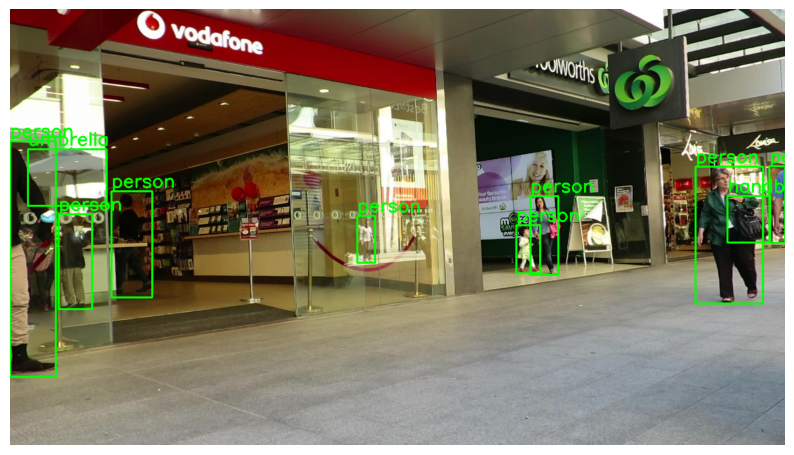

In [17]:
# Display example detection
object_detection_api(img_ex_path, threshold=0.8)

### The picture above is an example of applying Detection Network (in our case, Faster R-CNN).

### Justification for Using the Pretrained Faster R-CNN Model
We experimented with multiple hyperparameter changes to fine-tune the Faster R-CNN model for the selected dataset, but the prediction scores remained significantly below the required threshold of 0.5.

Observed Prediction Scores: [0.072554335, 0.06941526]

**Key experiments conducted:**

1. Adjusted various hyperparameters, including **learning rate, weight decay, number of epochs, reduction methods, and batch size**, but did not achieve a notable improvement in prediction scores.

2. **Increasing the number of epochs** led to a reduction in loss, but the prediction scores still remained low.

3. Further fine-tuning may require **significantly more training time and computational resources** to yield meaningful improvements.

4. The **pretrained Faster R-CNN model already appears to be an optimal choice** for this dataset, as fine-tuning does not provide substantial gains.

Given these observations, we are proceeding with the **pretrained Faster R-CNN model** for assignment submission.

### Implement adaptive tracking algorithms (e.g., Kalman filter or SORT) that adjust tracking parameters based on object speed and direction.

* We have tried with both Sort and Kalman filter. Kalman filter is providing better results than Sort with the given dataset.

* We are also facing some issue while setting up environment with google colab. we had to make some manual changes into sort/sort.py

In [18]:
# Kalman Filter for object tracking

class KalmanTracker:
    def __init__(self):
        self.kf = cv2.KalmanFilter(4, 2)  # 4 states, 2 measurements
        self.kf.transitionMatrix = np.array([[1, 0, 1, 0],
                                             [0, 1, 0, 1],
                                             [0, 0, 1, 0],
                                             [0, 0, 0, 1]], np.float32)

        self.kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                              [0, 1, 0, 0]], np.float32)

        self.kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
        self.kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.1
        self.kf.errorCovPost = np.eye(4, dtype=np.float32)
        self.kf.statePost = np.random.rand(4, 1).astype(np.float32)

    def predict(self):
        pred = self.kf.predict()
        if pred is None:
            raise ValueError("KalmanFilter.predict() returned None! Check initialization.")
        return pred[:2]

    def update(self, measurement):
        self.kf.correct(np.array(measurement, dtype=np.float32))

# Object tracking using Kalman filter
tracker = KalmanTracker()
save_path = join(MOT_PATH, 'save/')
for key in list_motdata:
    img = cv2.imread(os.path.join(motdata, key))
    pred_boxes, pred_classes = get_prediction(os.path.join(motdata, key), 0.5)
    for box, label in zip(pred_boxes, pred_classes):
        measurement = np.array([box[0][0], box[0][1]])
        tracker.update(measurement)
        pred_state = tracker.predict()

        cv2.rectangle(img, (int(pred_state[0]), int(pred_state[1])), (int(box[1][0]), int(box[1][1])), (0, 255, 255), 4)
        # Add label text above the bounding box
        label_position = (int(pred_state[0]), int(pred_state[1]) - 10)  # Slightly above the box
        cv2.putText(img, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2, cv2.LINE_AA)
    cv2.imwrite(join(save_path, key.replace('.jpg', '_kalman.jpg')), img)

  cv2.rectangle(img, (int(pred_state[0]), int(pred_state[1])), (int(box[1][0]), int(box[1][1])), (0, 255, 255), 4)

  label_position = (int(pred_state[0]), int(pred_state[1]) - 10)  # Slightly above the box







*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.






### Evaluate the model's performance using metrics such as mean Average Precision (mAP), tracking accuracy, and identity switch rate.




*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a lable given into COCO




In [19]:
img_path = motdata    # img root path

# Making new directory for saving results
save_path = join(MOT_PATH,'save/')
!mkdir "{save_path}"

mkdir: cannot create directory ‘MOT/save/’: File exists


* We have saved all the images with object detection into save folder. All the images can be seen with boxes of dectected objects.

In [20]:
# Evaluation Metrics
import math

def compute_distance(gt, pred):
    """
    Computes the Euclidean distance between a ground truth object and a predicted object.
    """
    # Accessing the bounding box coordinates directly from nested lists
    gt_x, gt_y, _, _ = gt[1] if isinstance(gt[1], list) else gt
    pred_x, pred_y, _, _ = pred[1] if isinstance(pred[1], list) else pred

    return math.sqrt((gt_x - pred_x) ** 2 + (gt_y - pred_y) ** 2)


# Tracking Accuracy (MOTA & MOTP)
def compute_mota_motp(ground_truth, predictions):
    """
    Compute MOTA and MOTP given ground truth and predicted annotations.
    Returns: MOTA, MOTP, along with FP, FN, and ID switches for debugging.
    """
    num_gt_objects = 0  # Initialize to 0 to count correctly
    for frame_id in ground_truth:
        num_gt_objects += len(ground_truth[frame_id])  # Sum objects across all frames

    false_positives = 0
    false_negatives = 0
    id_switches = 0
    total_distance = 0
    total_matches = 0
    prev_assignments = {}  # Stores object assignments from previous frame

    # predictions with ground truth
    for frame_id in ground_truth:
        gt_objects = ground_truth[frame_id]
        pred_objects = predictions.get(frame_id, [])

        # matching logic
        matched = set()  # Keep track of matched prediction IDs
        current_assignments = {}

        for gt in gt_objects:
            best_match = None
            min_distance = float("inf")

            for pred in pred_objects:
                distance = compute_distance(gt, pred)
                if distance < min_distance:
                    min_distance = distance
                    best_match = pred

            if best_match:
                # Add the prediction ID to the matched set (instead of the entire list)
                matched.add(best_match[0])  # Assuming best_match is (object_id, bbox)
                current_assignments[gt[0]] = best_match[0]  # Map GT ID → Predicted ID
                total_distance += min_distance
                total_matches += 1
            else:
                false_negatives += 1

        false_positives += len(pred_objects) - len(matched)

        # Count ID switches by comparing current assignments to previous frame
        if prev_assignments:
            for gt_id, pred_id in current_assignments.items():
                if gt_id in prev_assignments and prev_assignments[gt_id] != pred_id:
                    id_switches += 1

        prev_assignments = current_assignments  # Update assignments for next frame

    # Compute MOTA
    mota = 1 - (false_positives + false_negatives + id_switches) / max(num_gt_objects, 1)

    # Compute MOTP
    motp = (total_distance / total_matches) if total_matches > 0 else 0

    # Compute ID Switch Rate
    idsw_rate = id_switches / max(num_gt_objects, 1)

    return mota, motp, false_positives, false_negatives, idsw_rate, num_gt_objects, total_distance, total_matches




In [21]:

def save_predictions(tracker_predictions, output_path):
    """
    Saves tracker predictions to a file in MOT format.
    tracker_predictions: Dictionary {frame_id: [(object_id, [x, y, width, height])]}
    output_path: Path to save the predictions.txt file.
    """
    with open(output_path, "w") as f:
        for frame_id, objects in tracker_predictions.items():
            for object_id, bbox in objects:
                x, y, w, h = bbox
                f.write(f"{frame_id},{object_id},{x},{y},{w},{h},1,-1,-1,-1\n")  # Format: frame, id, bbox, conf, class, etc.

# Example: Assume `tracker_results` stores the tracked objects per frame
tracker_results = {
    1: [(1, [100, 200, 50, 80]), (2, [150, 250, 60, 90])],
    2: [(1, [110, 210, 50, 80]), (2, [160, 260, 60, 90])],
}

prediction_path = "MOT/train/MOT17-09/predictions.txt"
save_predictions(tracker_results, prediction_path)


def load_ground_truth(gt_path):
    """
    Load ground truth bounding boxes from MOTChallenge format.
    """
    ground_truth = {}
    with open(gt_path, "r") as f:
        for line in f:
            data = line.strip().split(",")
            frame_id = int(data[0])
            object_id = int(data[1])
            bbox = list(map(float, data[2:6]))  # x, y, width, height

            if frame_id not in ground_truth:
                ground_truth[frame_id] = []
            ground_truth[frame_id].append((object_id, bbox))
    return ground_truth

# Path to the ground truth file
gt_path = "MOT/train/MOT17-09/gt/gt.txt"
ground_truth_annotations = load_ground_truth(gt_path)

def load_predictions(prediction_path):
    """
    Load predicted bounding boxes from model output.
    """
    predictions = {}
    with open(prediction_path, "r") as f:
        for line in f:
            data = line.strip().split(",")
            frame_id = int(data[0])
            object_id = int(data[1])
            bbox = list(map(float, data[2:6]))  # x, y, width, height

            if frame_id not in predictions:
                predictions[frame_id] = []
            predictions[frame_id].append((object_id, bbox))
    return predictions

# Path where your predictions are saved
prediction_path = "MOT/train/MOT17-09/predictions.txt"
predicted_annotations = load_predictions(prediction_path)

# Compute MOTA & MOTP
mota, motp, false_positives, false_negatives, idsw_rate, num_gt_objects, total_distance, total_matches = compute_mota_motp(ground_truth_annotations, predicted_annotations)
print(f"MOTA: {mota:.2f}, MOTP: {motp:.2f}")

print(f"False Positives (FP): {false_positives}")
print(f"False Negatives (FN): {false_negatives}")
print(f"ID Switches: {idsw_rate}")
print(f"Ground Truth Objects: {num_gt_objects}")

print(f"Total Distance Error: {total_distance}")
print(f"Total Matches: {total_matches}")


MOTA: 0.00, MOTP: 827.52
False Positives (FP): 0
False Negatives (FN): 10385
ID Switches: 0.0
Ground Truth Objects: 10411
Total Distance Error: 21515.522900574026
Total Matches: 26


### Compiling all the saved frames into video gif & mp4

In [22]:
import imageio
import moviepy.editor as mp
from IPython.display import display, Image, Video

save_path = join(MOT_PATH, 'save/')
output_gif = join(save_path, "tracking_output.gif")
output_video = join(save_path, "tracking_output.mp4")

# Get list of processed images
frames = sorted([f for f in os.listdir(save_path) if f.endswith("_kalman.jpg")])

# Create GIF
with imageio.get_writer(output_gif, mode='I', duration=0.1) as writer:
    for frame in frames:
        img_path = join(save_path, frame)
        img = imageio.imread(img_path)
        writer.append_data(img)



  img = imageio.imread(img_path)




*   Check 'tracking_output.gif' for whole demo experience.




In [23]:
from IPython.display import Image
Image(output_gif)


In [24]:
# Convert GIF to Video
clip = mp.VideoFileClip(output_gif)
clip.write_videofile(output_video, fps=10)

# Display the video
display(Video(output_video, embed=True))

Moviepy - Building video MOT/save/tracking_output.mp4.
Moviepy - Writing video MOT/save/tracking_output.mp4



Moviepy - Done !
Moviepy - video ready MOT/save/tracking_output.mp4


We can observe that model is able to detect multiple objects into given frame and label it accordingly though the results are not accurate.

### We can download the tracking_output.gif. It gives a nice demo of complete process.
* gif file is not playable into colab canvas.
* Somehow mp4 file is not playable even after download.